In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import pymc3 as pm
import theano

print('Running on PyMC3 v{}'.format(pm.__version__))

Running on PyMC3 v3.9.3


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use('default')

# A Tour of Model Checking techniques using PyMC3

<br />
<br />
<br />
<br />
<br />
<br />

Rob Zinkov

1.  Introduction
2.  Setting up example problem
3.  Motivate why model checking is necessary
4.  Cross validation and predictive accuracy / LOO
5.  Prior & Posterior Predictive Checks / Population Predictive Checks
6.  BIC / DIC / WAIC
7.  Likelihood on heldout data
8.  Marginal Likelihood
9.  Likelihood ratios, Bayes factors
10. MMD / relative MMD / Kernel Stein Discrepancy / Witness function
11. Posterior dispersion indices
12. Flowchart of when to use different techniques


# Introduction

One of the ongoing challenges when fitting models is figuring out
if what we have is any good.

The issue is there a good guidelines on the model fitting side,
but less so on model evaluation side

I'll go over several methods that exist to give an overview of
how to evaluate and compare different models.

I will cover both Bayesian *and* Frequentist methods. They each
have their places and evaluating models is a place where both can shine

## Model Evaluation vs Model Selection

While I consider these to be two aspects of the same process sometimes it'll help to distinguish

*Model Evaluation* asks is my model of the data any good?

<small>(Sometimes is called Model checking or Model criticism)</small>

*Model Selection* asks which of these models is the best fit for my data

<small>(Sometimes is called Model comparison)</small>


 <img src="bayesian_workflow.png" style="height: 800px;"/>

# Assumptions and Cavaets

* Assuming you have run and fit a few models in pymc3
* I won't nor can cover all goodness of fit tests
* Not all tests are or should be natively supported by pymc3

# Running example

<img src="7758459_orig.jpg " />

Radon is an odorless colorless gas that in high concentrations is known to cause
lung cancer. Levels vary from household to household but also geographically.

The EPA conducted a study and found out that the presence of a basement as well
as general levels of uranium in the level are predictive of radon levels.



<center><img src="radon-map-enlarged.jpg" /></center>

## Running example

Gelman et al. (2013) use a hierarchical Bayesian model to fit and predict
radon levels. These and other models have been ported to pymc3 and the radon
data comes included with the library.

So we'll be using these models as a running example of picking between different models

https://docs.pymc.io/notebooks/multilevel_modeling.html
by Chris Fonnesbeck covers the models themselves in more detail

In [3]:
# Read data
srrs2 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns = srrs2.columns.map(str.strip)
srrs_mn = srrs2[srrs2.state == "MN"].copy()

# Add county information
srrs_mn.county = srrs_mn.county.map(str.strip)
mn_counties = srrs_mn.county.unique()
counties = len(mn_counties)
county_lookup = dict(zip(mn_counties, range(counties)))

county = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon = srrs_mn["radon"] = srrs_mn.activity
srrs_mn["log_radon"] = log_radon = np.log(radon + 0.1).values
floor = srrs_mn.floor.values

## Radon prediction

The way this works is we will try to predict radon levels based on:

1. What county the house is located in
2. Whether the measurement was taken in the Basement (floor 0) or Ground Level (floor 1)

In [4]:
srrs_mn[['floor', 'county', 'radon']].head(n=10).style.hide_index()

floor,county,radon
1,AITKIN,2.200000
0,AITKIN,2.200000
0,AITKIN,2.900000
0,AITKIN,1.000000
0,ANOKA,3.100000
0,ANOKA,2.500000
0,ANOKA,1.500000
0,ANOKA,1.000000
0,ANOKA,0.700000
0,ANOKA,1.200000


In [5]:
srrs_mn.groupby(['county']).size().sort_values().reset_index(name='counts')

,county,counts
0,WILKIN,1
1,MAHNOMEN,1
2,MURRAY,1
3,YELLOW MEDICINE,2
4,LAC QUI PARLE,2
...,...,...
80,WASHINGTON,46
81,ANOKA,52
82,DAKOTA,63
83,HENNEPIN,105


## Radon prediction

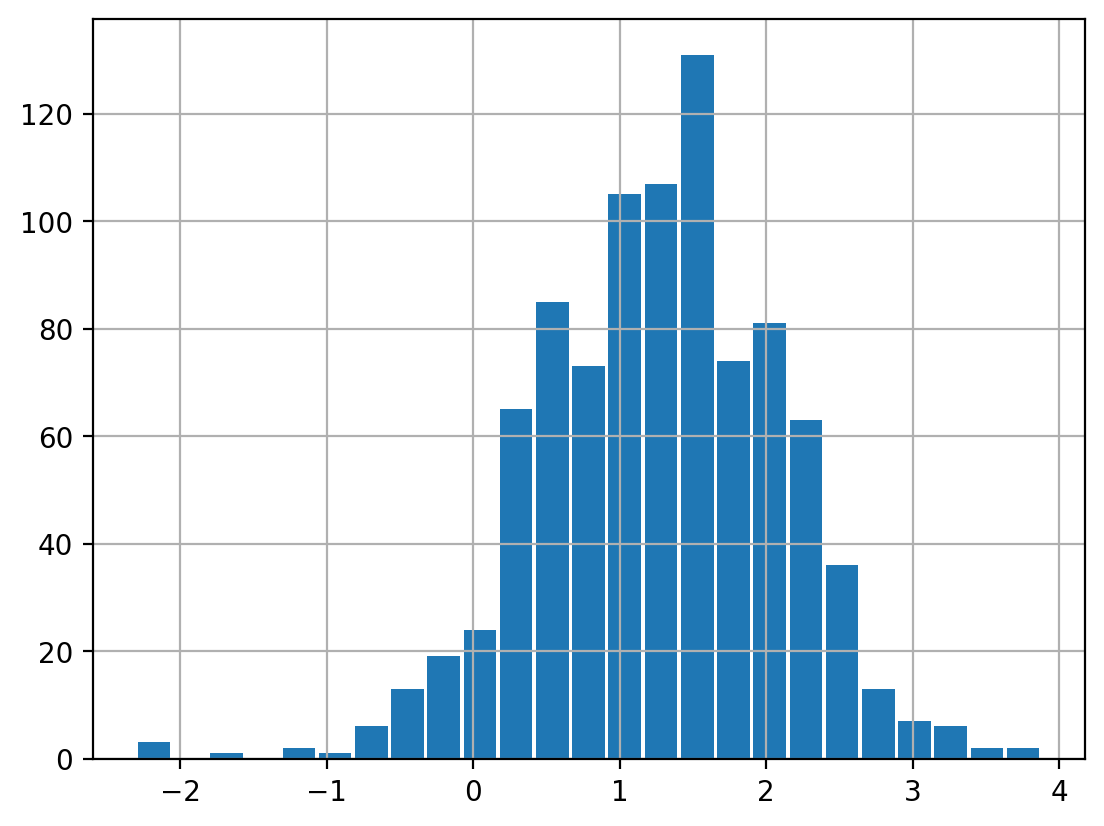

In [6]:
srrs_mn.log_radon.hist(bins=25, rwidth=0.9);

## Radon prediction models

**Complete pooling:**

Treat all counties the same, and estimate a single radon level.

$$ y_i = \alpha +\beta x_i + \epsilon_i $$

**No pooling:**

Model radon in each county independently.

$$ y_i = \alpha_{j[i]} +\beta x_i + \epsilon_i $$

where $j=1,\ldots,85$

## Radon prediction models (continued)


**Partial pooling**

$$ y_i = \alpha_{j[i]} +\beta x_i + \epsilon_i $$

$$ \alpha_{j[i]} \sim \mathcal{N}(\mu_\alpha, \sigma^2_\alpha) $$

where $j=1,\ldots,85$

# Predictive accuracy

The best way to evaluate models is on some downstream task



## Predictive accuracy

One way to evaluate this is to set aside some data and see
if our model can predict the true value from this unseen data.



In [7]:
def split_data(df, fraction=0.2):
    out_sample = df.sample(frac = fraction) 
    in_sample = df.drop(out_sample.index)
    return in_sample, out_sample

In [8]:
# Set aside some of the data
srrs_in_sample, srrs_out_sample = split_data(srrs_mn, fraction=0.1)

county_in = srrs_in_sample.county_code.values
radon_in = srrs_in_sample.log_radon.values
floor_in = srrs_in_sample.floor.values

county_out = srrs_out_sample.county_code.values
radon_out = srrs_out_sample.log_radon.values
floor_out = srrs_out_sample.floor.values

In [9]:
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor_in.size)
}
with pm.Model(coords=coords) as pooled_model:
    floor_idx = pm.Data("floor_idx", floor_in, dims="obs_id")
    b = pm.Normal("b", 0.0, sigma=10.0, dims="Level")

    theta = b[floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", radon_in, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    pooled_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


In [10]:
az.summary(pooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],1.351,0.030,1.295,1.406,0.001,0.000,2366.0,2366.0,2358.0,1301.0,1.0
b[1],0.776,0.065,0.647,0.890,0.001,0.001,2753.0,2753.0,2757.0,1248.0,1.0
sigma,0.768,0.020,0.731,0.805,0.000,0.000,2511.0,2511.0,2502.0,1430.0,1.0


In [11]:
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor_in.size),
    "County": mn_counties
}
with pm.Model(coords=coords) as unpooled_model:
    floor_idx = pm.Data("floor_idx", floor_in, dims="obs_id")
    county_idx = pm.Data("county_idx", county_in, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims=("County", "Level"))

    theta = a[county_idx, floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", radon_in, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    unpooled_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 9 seconds.


In [12]:
az.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"a[0,0]",0.667,0.397,-0.045,1.456,0.006,0.006,4175.0,2421.0,4194.0,1313.0,1.00
"a[0,1]",0.814,0.687,-0.390,2.177,0.012,0.013,3122.0,1316.0,3132.0,1267.0,1.00
"a[1,0]",0.964,0.102,0.769,1.148,0.002,0.001,2488.0,2469.0,2487.0,1529.0,1.00
"a[1,1]",-0.130,0.392,-0.839,0.605,0.007,0.009,2953.0,1044.0,2988.0,1490.0,1.00
"a[2,0]",1.501,0.696,0.214,2.860,0.012,0.010,3446.0,2648.0,3452.0,1316.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...
"a[83,0]",1.673,0.198,1.307,2.026,0.004,0.003,3134.0,3120.0,3126.0,1368.0,1.01
"a[83,1]",-0.263,9.747,-18.246,17.840,0.179,0.249,2970.0,765.0,2959.0,1447.0,1.00
"a[84,0]",1.202,0.480,0.328,2.138,0.008,0.007,3192.0,2722.0,3214.0,1468.0,1.00
"a[84,1]",0.085,10.109,-19.444,19.265,0.168,0.275,3613.0,677.0,3606.0,1146.0,1.00


In [13]:
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor_in.size),
    "County": mn_counties
}
with pm.Model(coords=coords) as partial_pooling:
    floor_idx = pm.Data("floor_idx", floor_in, dims="obs_id")
    county_idx = pm.Data("county_idx", county_in, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=10.0)

    # Expected value per county:
    theta = a_county[county_idx] + b * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", radon_in, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    partial_pooling_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.


In [22]:
# Hack since pm.find_MAP diverges

best_ll = -np.infty
best = None

pp_logp = partial_pooling.logp
for p in partial_pooling_trace:
    ll = pp_logp(p)
    if ll > best_ll:
        best = p
        best_ll = ll
        
partial_pooled_point_estimate = best

## Predictive accuracy

For continuous data root mean squared error (rmse) is a popular choice

$$ \text{RMSE}(Y) = \sqrt{\frac{1}{n}\sum_{i=1}^n(Y_i-\mathbb{E}[Y_i \mid \theta])^2}$$

In [14]:
def rmse(test_data, predicted):
    """Calculate root mean squared error.
    Ignoring missing values in the test data.
    """
    I = ~np.isnan(test_data)   # indicator for missing values
    N = I.sum()                # number of non-missing values
    sqerror = abs(test_data - predicted) ** 2  # squared error array
    mse = sqerror[I].sum() / N                 # mean squared error
    return np.sqrt(mse)

In [15]:
with pooled_model:
    pooled_point_estimate = pm.find_MAP(model=pooled_model)
    # change the value and shape of the data
    pm.set_data({
        "floor_idx": floor_out,
        # use dummy values with the same shape:
        "radon": radon_out,
    })

    post_pred = pm.sample_posterior_predictive(pooled_trace)

In [16]:
preds = post_pred["y"].mean(axis=0)
# lower is better
rmse(preds, radon_out)

0.9721695872119326

In [17]:
with unpooled_model:
    unpooled_point_estimate = pm.find_MAP(model=unpooled_model)
    # change the value and shape of the data
    pm.set_data({
        "floor_idx": floor_out,
        "county_idx": county_out,
        # use dummy values with the same shape:
        "radon": radon_out,
    })

    post_pred = pm.sample_posterior_predictive(unpooled_trace)

In [18]:
preds = post_pred["y"].mean(axis=0)
# lower is better
rmse(preds, radon_out)

1.0243686247273727

In [19]:
with partial_pooling:
    # change the value and shape of the data
    pm.set_data({
        "floor_idx": floor_out,
        "county_idx": county_out,
        # use dummy values with the same shape:
        "radon": radon_out,
    })

    post_pred = pm.sample_posterior_predictive(partial_pooling_trace)

In [20]:
preds = post_pred["y"].mean(axis=0)
# lower is better
rmse(preds, radon_out)

0.9299338549155656

# Cross validation

## Cross validation

Predictive accuracy is based on a single split which introduces bias. We can do multiple
splits and average the accuracy across these splits. This is called *cross-validation*

Exercise 1:

Implement cross-validation and report results on radon models

# Likelihood on held-out data

## Held-out likelihood

In the same spirit of predictive accuracy, we can simply ask on unseen data, which of the models is least “surprised”

In [23]:
pooled_point_estimate["y"] = radon_out
unpooled_point_estimate["y"] = radon_out
partial_pooled_point_estimate["y"] = radon_out

print("Pooled model LL:", pooled_model.logp(pooled_point_estimate))
print("Unpooled model LL:", unpooled_model.logp(unpooled_point_estimate))
print("Partially-pooled model LL:", partial_pooling.logp(partial_pooled_point_estimate))

Pooled model LL: -141.3818492829713
Unpooled model LL: -710.3533170768483
Partially-pooled model LL: -128.2446075503398


# Marginal Likelihood

Marginal likelihood measures the probability of observing our data under the model family. This is also more Bayesian as we don't use a point estimate of our parameters

In [24]:
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor.size)
}
with pm.Model(coords=coords) as pooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    b = pm.Normal("b", 0.0, sigma=10.0, dims="Level")

    theta = b[floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", log_radon, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    pooled_trace = pm.sample(random_seed=42)
    
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor.size),
    "County": mn_counties
}
with pm.Model(coords=coords) as unpooled_model:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    a = pm.Normal("a", 0.0, sigma=10.0, dims=("County", "Level"))

    theta = a[county_idx, floor_idx]
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", log_radon, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    unpooled_trace = pm.sample(random_seed=42)
    
coords = {
    "Level": ["Basement", "Floor"],
    "obs_id": np.arange(floor.size),
    "County": mn_counties
}
with pm.Model(coords=coords) as partial_pooling:
    floor_idx = pm.Data("floor_idx", floor, dims="obs_id")
    county_idx = pm.Data("county_idx", county, dims="obs_id")
    # Hyperpriors:
    a = pm.Normal("a", mu=0.0, sigma=10.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)

    # Varying intercepts:
    a_county = pm.Normal("a_county", mu=a, sigma=sigma_a, dims="County")
    # Common slope:
    b = pm.Normal("b", mu=0.0, sigma=10.0)

    # Expected value per county:
    theta = a_county[county_idx] + b * floor_idx
    # Model error:
    sigma = pm.Exponential("sigma", 1.0)

    radon_shared = pm.Data("radon", log_radon, dims="obs_id")
    y = pm.Normal("y", theta, sigma=sigma, observed=radon_shared, dims="obs_id")
    partial_pooling_trace = pm.sample(random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a_county, sigma_a, a]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 8 seconds.


In [25]:
with pooled_model:
    pooled_smc_trace = pm.sample_smc(4000)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.015
Stage:   6 Beta: 0.037
Stage:   7 Beta: 0.092
Stage:   8 Beta: 0.238
Stage:   9 Beta: 0.608
Stage:  10 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.007
Stage:   5 Beta: 0.015
Stage:   6 Beta: 0.036
Stage:   7 Beta: 0.090
Stage:   8 Beta: 0.230
Stage:   9 Beta: 0.588
Stage:  10 Beta: 1.000


In [26]:
with unpooled_model:
    unpooled_smc_trace = pm.sample_smc(4000)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.001
Stage:   4 Beta: 0.003
Stage:   5 Beta: 0.006
Stage:   6 Beta: 0.011
Stage:   7 Beta: 0.019
Stage:   8 Beta: 0.028
Stage:   9 Beta: 0.039
Stage:  10 Beta: 0.050
Stage:  11 Beta: 0.063
Stage:  12 Beta: 0.076
Stage:  13 Beta: 0.089
Stage:  14 Beta: 0.104
Stage:  15 Beta: 0.120
Stage:  16 Beta: 0.137
Stage:  17 Beta: 0.154
Stage:  18 Beta: 0.173
Stage:  19 Beta: 0.195
Stage:  20 Beta: 0.216
Stage:  21 Beta: 0.239
Stage:  22 Beta: 0.264
Stage:  23 Beta: 0.292
Stage:  24 Beta: 0.323
Stage:  25 Beta: 0.354
Stage:  26 Beta: 0.390
Stage:  27 Beta: 0.427
Stage:  28 Beta: 0.468
Stage:  29 Beta: 0.513
Stage:  30 Beta: 0.561
Stage:  31 Beta: 0.614
Stage:  32 Beta: 0.673
Stage:  33 Beta: 0.737
Stage:  34 Beta: 0.807
Stage:  35 Beta: 0.882
Stage:  36 Beta: 0.964
Stage:  37 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
S

In [27]:
with partial_pooling:
    partial_smc_trace = pm.sample_smc(4000)

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.006
Stage:   5 Beta: 0.011
Stage:   6 Beta: 0.029
Stage:   7 Beta: 0.054
Stage:   8 Beta: 0.089
Stage:   9 Beta: 0.139
Stage:  10 Beta: 0.201
Stage:  11 Beta: 0.276
Stage:  12 Beta: 0.363
Stage:  13 Beta: 0.461
Stage:  14 Beta: 0.572
Stage:  15 Beta: 0.696
Stage:  16 Beta: 0.830
Stage:  17 Beta: 0.969
Stage:  18 Beta: 1.000
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.001
Stage:   3 Beta: 0.003
Stage:   4 Beta: 0.005
Stage:   5 Beta: 0.011
Stage:   6 Beta: 0.019
Stage:   7 Beta: 0.034
Stage:   8 Beta: 0.063
Stage:   9 Beta: 0.111
Stage:  10 Beta: 0.171
Stage:  11 Beta: 0.243
Stage:  12 Beta: 0.326
Stage:  13 Beta: 0.419
Stage:  14 Beta: 0.522
Stage:  15 Beta: 0.633
Stage:  16 Beta: 0.751
Stage:  17 Beta: 0.875
Stage:  18 Beta: 1.000


In [28]:
print("pooled marginal_likelihood:", pooled_smc_trace.report.log_marginal_likelihood)
print("unpooled marginal likelihood:", unpooled_smc_trace.report.log_marginal_likelihood)
print("partial_pooling marginal_likelihood:", partial_smc_trace.report.log_marginal_likelihood)

pooled marginal_likelihood: [-1101.22611358 -1101.18021879]
unpooled marginal likelihood: [-2283.75780614 -2288.24476468]
partial_pooling marginal_likelihood: [-1075.34181204 -1070.76515456]


## Bayes factors

Marginal likelihoods are nice for evaluating models but they can be used to compare models 

## Bayes factors

The intuition is suppose we have two models $p(M_0 \mid y)$ and $p(M_1 \mid y)$ and we want to choose between them


## Bayes factors

Thanks to some algebra we don't need to compute the normalising constants and just need
the likelihoods and the priors for the models.

$$
\begin{align}
BF &= \frac{p(y|M_0)}{p(y|M_1)} \\
&= \frac{\int p(\theta_0|M_0)p(D|\theta_0,M_0)\,d\theta_0}
{\int p(\theta_1|M_1)p(y|\theta_1,M_1)\,d\theta_1} \\
&= \frac{\frac{p(M_0|y)p(y)}{p(M_0)}}{\frac{p(M_1|y)p(y)}{p(M_1)}} \\
&= \frac{p(M_0|y)}{p(M_1|y)}\frac{p(M_1)}{p(M_0)}
\end{align}
$$

We assume each model is equally likely

## Bayes factors

This ratio has some informal intuition over how much you said favour $M_0$ over $M_1$

* 1-3: anecdotal
* 3-10: moderate
* 10-30: strong
* 30-100: very strong
* 100+: extreme

## Bayes factors drawbacks

1. Must be a pair of models
2. Results are sensitive to latent variables
3. Made for discrete set of models

In [29]:
BF_smc = np.exp(partial_smc_trace.report.log_marginal_likelihood - 
                pooled_smc_trace.report.log_marginal_likelihood)
print(round(BF_smc[0]))

174344931409


# Prior & Posterior Predictive Checks

## Prior Predictive Checks

Prior Predictive Checks are there to check if your priors are reasonable by comparing them to your data

In [30]:
with pooled_model:
    prior_check = pm.sample_prior_predictive(samples=50, random_seed=42)

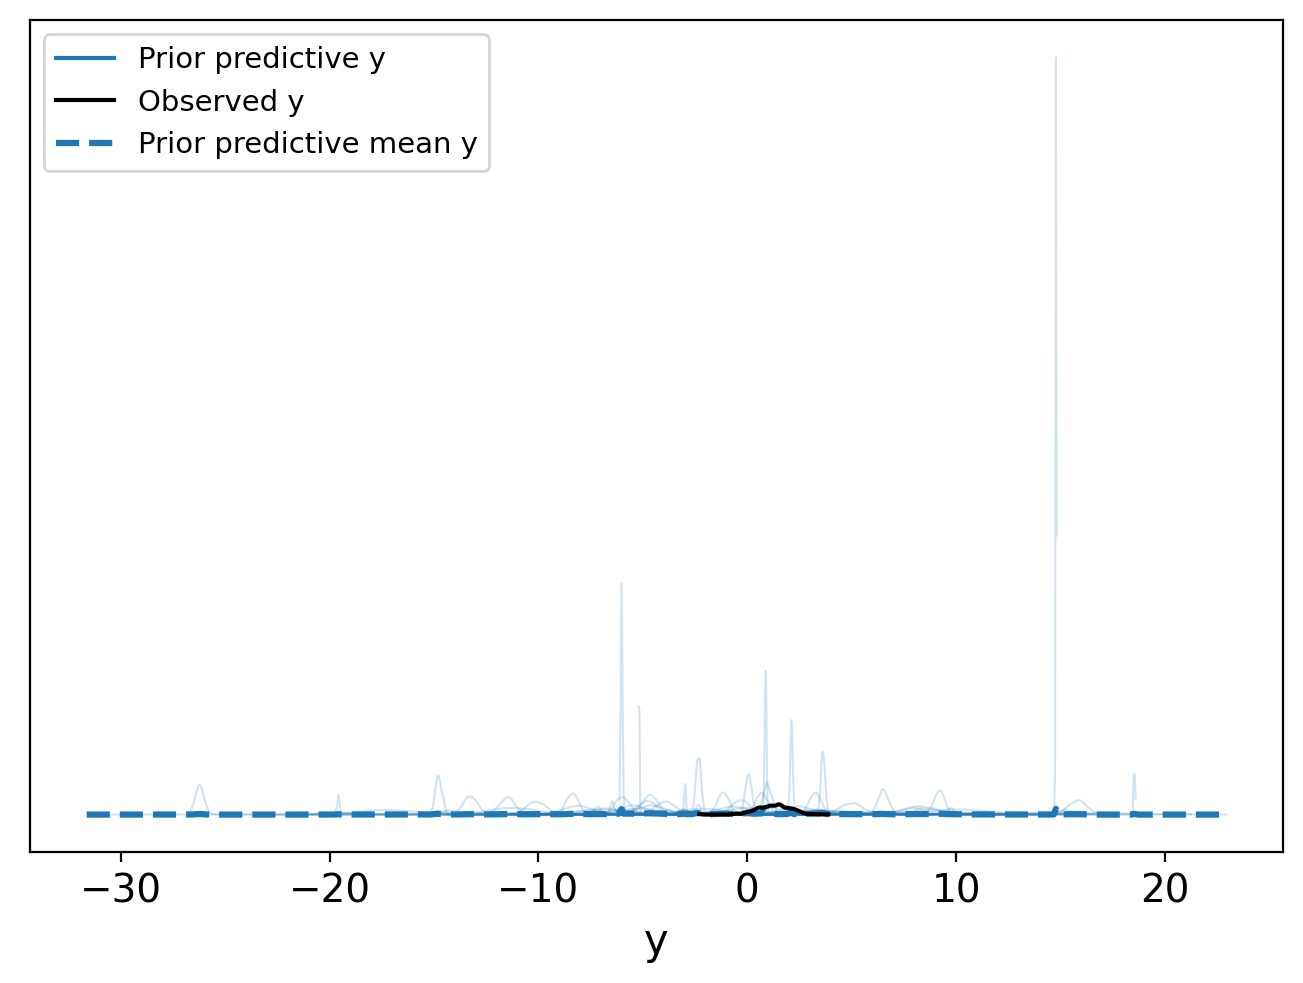

In [31]:
idata = az.from_pymc3(pooled_trace, prior=prior_check)
az.plot_ppc(idata, group='prior');

Exercise 2:

Adjust radon models to use a more realistic prior. Does this lead to improved models? Why or why not?

## Posterior Predictive Checks

Posterior Predictive Checks allow us to see if after our model is fitted does it generate replicated data
that resembles our observed data

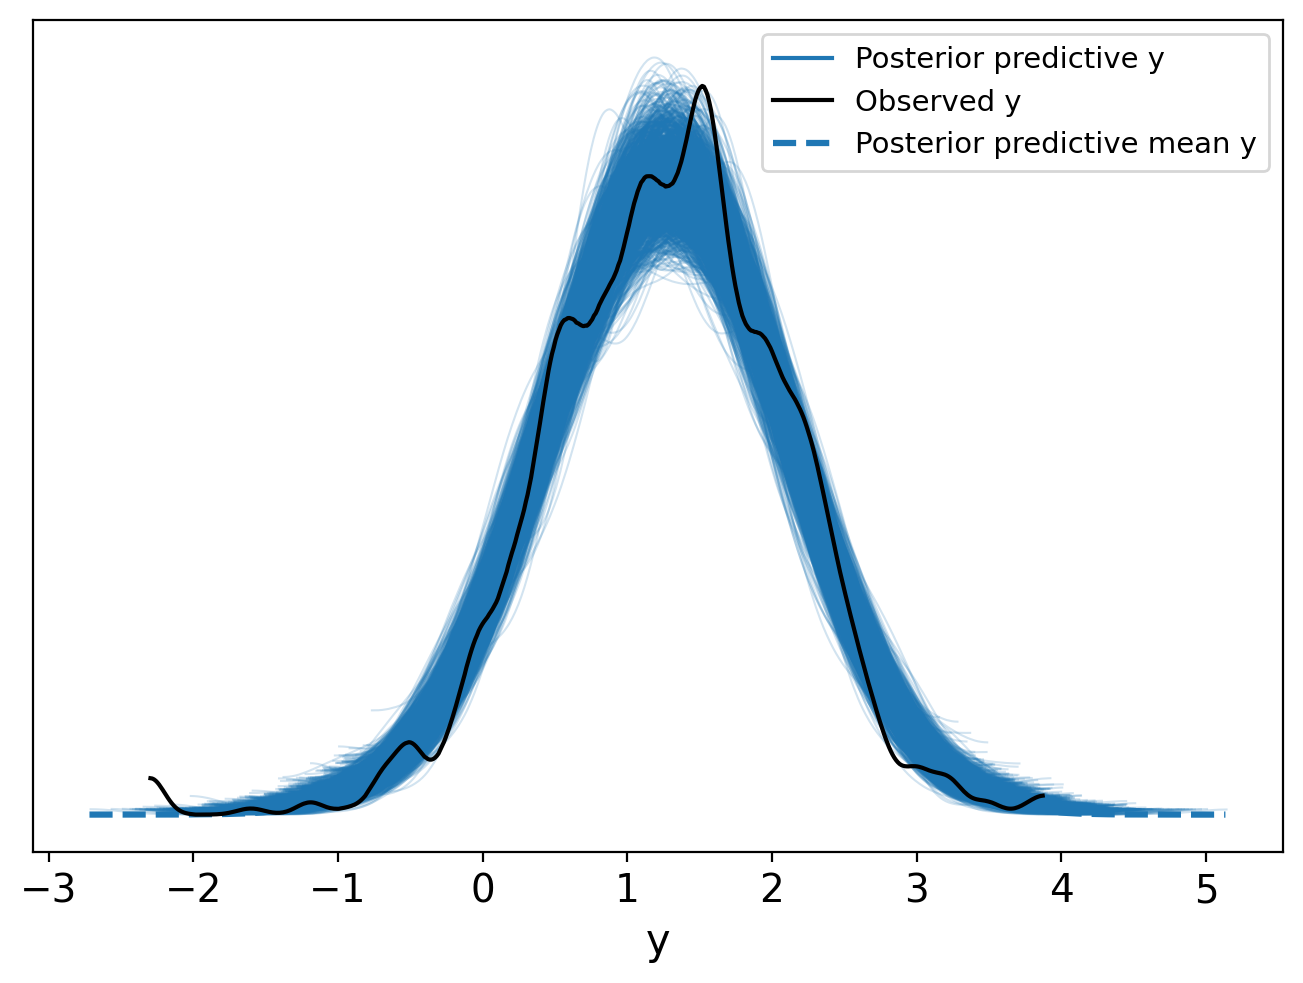

In [32]:
with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=42)
idata = az.from_pymc3(pooled_trace, posterior_predictive=ppc)
az.plot_ppc(idata);

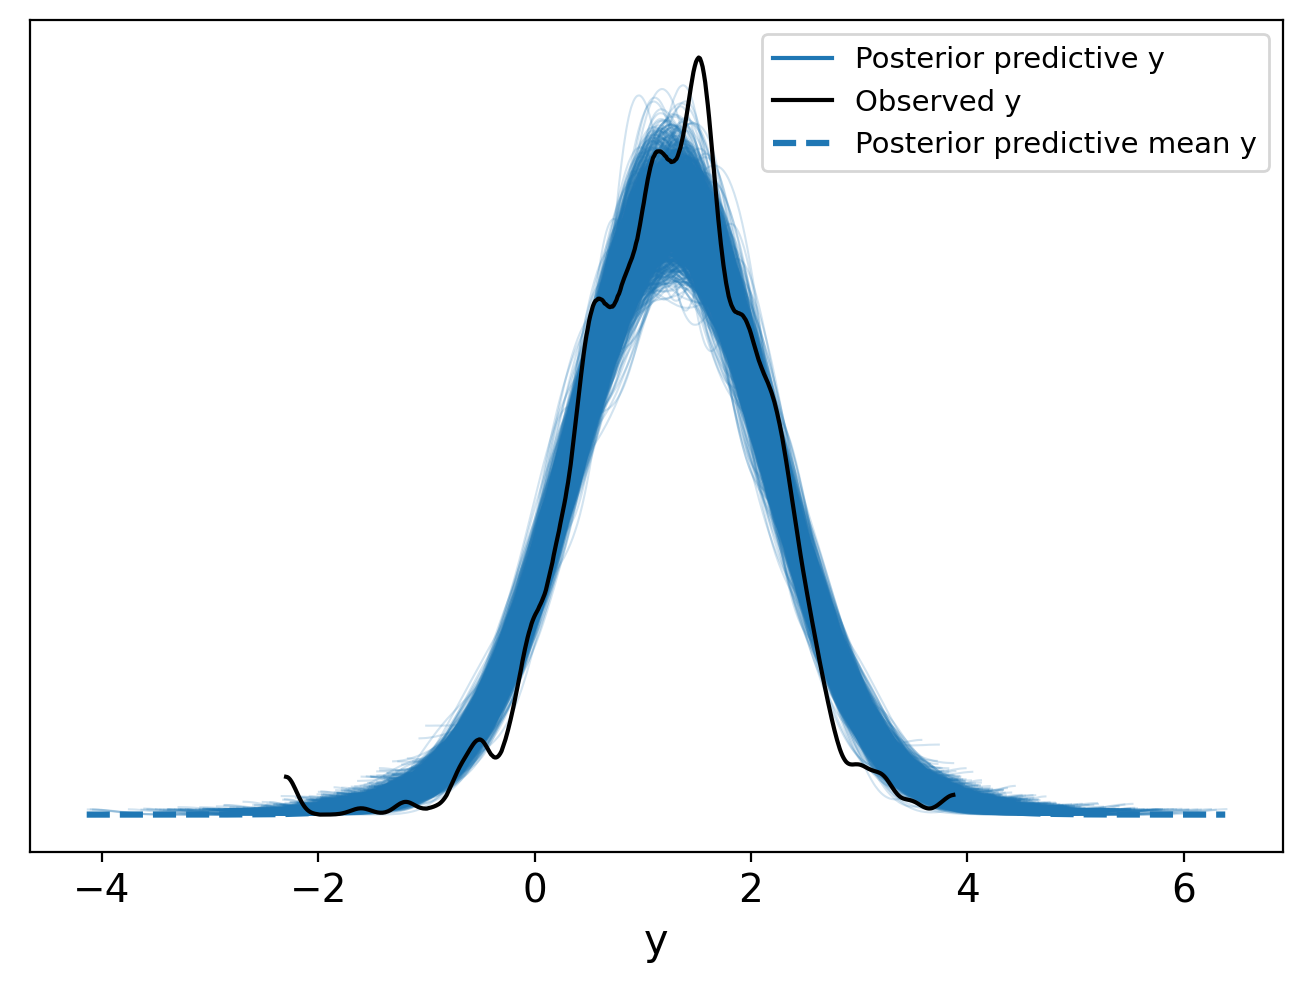

In [33]:
with unpooled_model:
    ppc = pm.sample_posterior_predictive(unpooled_trace, random_seed=42)
idata = az.from_pymc3(unpooled_trace, posterior_predictive=ppc)
az.plot_ppc(idata);

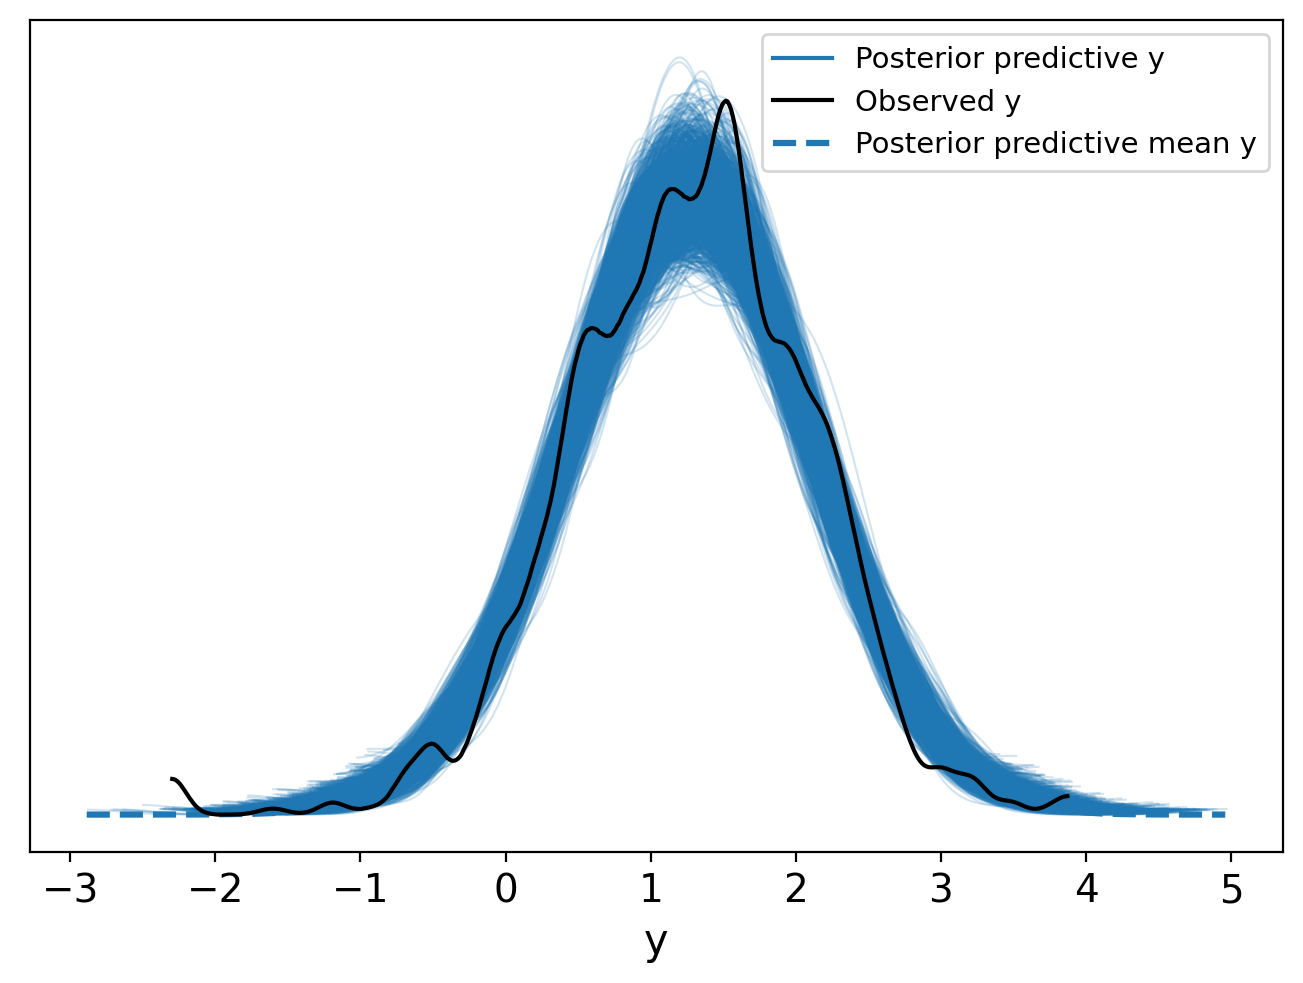

In [34]:
with partial_pooling:
    ppc = pm.sample_posterior_predictive(partial_pooling_trace, random_seed=42)
    
idata = az.from_pymc3(partial_pooling_trace, posterior_predictive=ppc)
az.plot_ppc(idata);

## Posterior Predictive Checks

We usually in PyMC3 and Stan we usually plot our observed data and compare to posterior predictive distribution visually.

But any discrepancy measure can be used here.

# Information Criterions

## Information Criterions

Sometimes though, we want a single number to just be able to score our models. These are called *information criterions*

## Akaike information criterion (AIC)

$$ -2\log p(y \mid \hat{\theta}) + 2\text{dim}(\hat{\theta}) $$

where $\hat{\theta} = \text{argmax}_\theta \, p(y \mid \theta)$

Not very Bayesian

## Bayesian information criterion (BIC)

$$ -2\log p(y \mid \hat{\theta}) + \text{dim}(\hat{\theta}) \log n $$

where $\hat{\theta} = \text{argmax}_\theta \, p(y \mid \theta)$

Still not very Bayesian

## Deviance information criterion (DIC)

$$ 2\left(\log p(y \mid \mathbb{E}[\theta \mid y]) - \mathbb{E}[\log p(y \mid \theta)]\right) $$

where both expectations are over $p(\theta \mid y)$

Kinda unstable

Exercise 3:

Implement AIC, BIC, and DIC for the radon models?

Hint: `model.ndim` gives the number of parameters

## Watanabe-Akaike or widely available information criterion (WAIC)

This measure is actually Bayesian and more stable than DIC

$$-2\frac{1}{n} \sum_{i=1}^n \log \mu(y_i) + \sigma^2_{log}(y_i)$$

where $\mu(y_i) = \mathbb{E}[p(y_i \mid \theta)]$ and $\sigma^2_{log}(y_i) = \mathbb{V}[\log p(y_i \mid \theta)]$

both $\mu$ and $\sigma^2_{log}$ and wrt to the $p(\theta \mid y)$ distribution

In [35]:
pm.compare({
    'pooled': pooled_trace,
    'unpooled': unpooled_trace,
    'partially_pooled': partial_pooling_trace,
    },
    scale="log",
    ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
partially_pooled,0,-1036.39,48.5404,0,0.999999,25.8018,0,True,log
unpooled,1,-1080.25,131.967,43.8558,2.10673e-07,30.7988,12.12,True,log
pooled,2,-1089.91,3.76284,53.5134,4.19402e-07,28.9869,10.6924,False,log


## Leave one out Cross-Validations (LOO-cv)

The idea behind LOO-cv is that we can repeatedly

1. Set aside one of our data points $y_i$
2. Fit a model on the rest of data $p(\theta \mid y_{-i})$
3. Evaluate $\log \mathbb{E}[y_i \mid \theta]$
4. Repeat for each data point and average the results

In [36]:
pm.compare({
    'pooled': pooled_trace,
    'unpooled': unpooled_trace,
    'partially_pooled': partial_pooling_trace,
    },
    scale="log",
    ic="loo")

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
partially_pooled,0,-1036.77,48.917,0,1,30.8789,0,False,log
pooled,1,-1089.91,3.76247,53.1363,1.60083e-09,27.4187,10.7068,False,log
unpooled,2,-1095.06,146.775,58.2868,2.9066e-13,24.192,12.5854,True,log


While LOO-CV is expensive to run, WAIC and other IC can be seen as fast approximations of it

# Posterior Dispersion Indices

<br />
<br />
<br />
<br />
<br />
<br />

Further reference:

Evaluating Bayesian Models with Posterior Dispersion Indices

Alp Kucukelbir, Yixin Wang, David M. Blei

In [37]:
from arviz.stats.stats_utils import get_log_likelihood as get_log_likelihood
from arviz.stats.stats_utils import logsumexp as logsumexp
from arviz.stats.stats_utils import make_ufunc as make_ufunc
from arviz.stats.stats_utils import stats_variance_2d as svar
from arviz.stats.stats_utils import wrap_xarray_ufunc as wrap_xarray_ufunc

def WAPDI(idata, model=None, varnames=None):
    log_likelihood = get_log_likelihood(idata, 'y')
    log_likelihood = log_likelihood.stack(sample=("chain", "draw"))
    shape = log_likelihood.shape
    n_samples = shape[-1]
    n_data_points = np.product(shape[:-1])

    ufunc_kwargs = {"n_dims": 1, "ravel": False}
    kwargs = {"input_core_dims": [["sample"]]}
    lppd_i = wrap_xarray_ufunc(
        logsumexp,
        log_likelihood,
        func_kwargs={"b_inv": n_samples},
        ufunc_kwargs=ufunc_kwargs,
        **kwargs,
    )

    vars_lpd = log_likelihood.var(dim="sample")
    return vars_lpd / lppd_i

y_pdi = WAPDI(az.from_pymc3(pooled_trace))

In [38]:
i = y_pdi.argsort()
#srrs_mn.iloc[int(i)]

data = srrs_mn[['county', 'radon', 'log_radon']]

data.iloc[i[:10]]

,county,radon,log_radon
5557,MCLEOD,0.0,-2.302585
5224,COTTONWOOD,0.0,-2.302585
5186,CARVER,0.0,-2.302585
5556,MCLEOD,25.4,3.238678
5685,REDWOOD,20.7,3.034953
5716,SCOTT,19.3,2.965273
5124,ANOKA,0.2,-1.203973
5318,FARIBAULT,0.1,-1.609438
5183,CARVER,14.7,2.694627
5162,BLUE EARTH,14.3,2.667228


In [39]:
data[data.county == "CARVER"]
#data[data.county == "MCLEOD"]
#data[data.county == "COTTONWOOD"]

,county,radon,log_radon
5181,CARVER,1.6,0.530628
5182,CARVER,12.9,2.564949
5183,CARVER,14.7,2.694627
5184,CARVER,4.7,1.568616
5185,CARVER,9.6,2.272126
5186,CARVER,0.0,-2.302585


# Two-Sample tests

# MMD / Relative MMD / Kernel Stein Discrepancy / Witness function

<center><img src="ipq_1.png" /></center>

<center><img src="ipq_2.png" /></center>

<center><img src="ipq_3.png" /></center>

<center><img src="mmd.png" /></center>

<center><img src="mmd2.png" /></center>

In [40]:
# Adapted from https://github.com/eugenium/MMD
from sklearn.metrics.pairwise import rbf_kernel
from scipy import stats

def grbf(x1, x2, sigma):
    '''Calculates the Gaussian radial base function kernel'''
    n, nfeatures = x1.shape
    m, mfeatures = x2.shape

    k1 = np.sum((x1*x1), 1)
    q = np.tile(k1, (m, 1)).transpose()
    del k1

    k2 = np.sum((x2*x2), 1)
    r = np.tile(k2.T, (n, 1))
    del k2

    h = q + r
    del q, r

    # The norm
    h = h - 2*np.dot(x1, x2.transpose())
    h = np.array(h, dtype=float)

    return np.exp(-1.*h/(2.*pow(sigma, 2)))


def kernelwidthPair(x1, x2):
    '''Implementation of the median heuristic. See Gretton 2012
       Pick sigma such that the exponent of exp(- ||x-y|| / (2*sigma2)),
       in other words ||x-y|| / (2*sigma2),  equals 1 for the median distance x
       and y of all distances between points from both data sets X and Y.
    '''
    n, nfeatures = x1.shape
    m, mfeatures = x2.shape

    k1 = np.sum((x1*x1), 1)
    q = np.tile(k1, (m, 1)).transpose()
    del k1

    k2 = np.sum((x2*x2), 1)
    r = np.tile(k2, (n, 1))
    del k2

    h = q + r
    del q, r

    # The norm
    h = h - 2*np.dot(x1, x2.transpose())
    h = np.array(h, dtype=float)

    mdist = np.median([i for i in h.flat if i])

    sigma = np.sqrt(mdist/2.0)
    if not sigma:
        sigma = 1

    return sigma


def kernelwidth(Zmed):
    '''Alternative median heuristic when we cant partition the points
    '''
    m = Zmed.shape[0]
    k1 = np.expand_dims(np.sum((Zmed*Zmed), axis=1), 1)
    q = np.kron(np.ones((1, m)), k1)
    r = np.kron(np.ones((m, 1)), k1.T)
    del k1

    h = q + r
    del q, r

    # The norm
    h = h - 2.*Zmed.dot(Zmed.T)
    h = np.array(h, dtype=float)

    mdist = np.median([i for i in h.flat if i])

    sigma = np.sqrt(mdist/2.0)
    if not sigma:
        sigma = 1

    return sigma


def MMD_Test(X, Y, sigma=-1, SelectSigma=2):
    if(sigma < 0):
        # Similar heuristics
        if(SelectSigma > 1):
            siz = np.min((1000, X.shape[0]))
            sigma = kernelwidthPair(X[0:siz], Y[0:siz])
        else:
            siz = np.min((1000, X.shape[0]*3))
            Zem = np.r_[X[0:siz/2], Y[0:siz/2]]
            sigma = kernelwidth(Zem)

    Kyy = grbf(Y, Y, sigma)
    Kxy = grbf(X, Y, sigma)
    Kyynd = Kyy-np.diag(np.diagonal(Kyy))
    m = Kxy.shape[0]
    n = Kyy.shape[0]

    u_yy = np.sum(Kyynd)*(1./(n*(n-1)))
    u_xy = np.sum(Kxy)/(m*n)

    # Compute the test statistic

    Kxx = grbf(X, X, sigma)
    Kxxnd = Kxx-np.diag(np.diagonal(Kxx))
    u_xx = np.sum(Kxxnd)*(1./(m*(m-1)))
    MMDXY = u_xx+u_yy-2.*u_xy
    return MMDXY

In [41]:
norm1 = np.random.normal(1., 1., (1000, 2))
norm2 = np.random.normal(0.2, 1., (1000, 2))

n = norm1.shape[0]
tt = MMD_Test(norm1, norm2)
pvalue = stats.norm.sf(tt, scale=(2.0/n)**0.5)
pvalue

3.248337337392221e-05

# Relative MMD

In [42]:
# Adapted from https://github.com/eugenium/MMD
import scipy as sp

def MMD_Diff_Var(Kyy, Kzz, Kxy, Kxz):
    '''
    Compute the variance of the difference statistic MMDXY-MMDXZ
    See http://arxiv.org/pdf/1511.04581.pdf Appendix for derivations
    '''
    m = Kxy.shape[0]
    n = Kyy.shape[0]
    r = Kzz.shape[0]

    Kyynd = Kyy-np.diag(np.diagonal(Kyy))
    Kzznd = Kzz-np.diag(np.diagonal(Kzz))

    u_yy = np.sum(Kyynd)*(1./(n*(n-1)))
    u_zz = np.sum(Kzznd)*(1./(r*(r-1)))
    u_xy = np.sum(Kxy)/(m*n)
    u_xz = np.sum(Kxz)/(m*r)

    # compute zeta1
    t1 = (1./n**3)*np.sum(Kyynd.T.dot(Kyynd))-u_yy**2
    t2 = (1./(n**2*m))*np.sum(Kxy.T.dot(Kxy))-u_xy**2
    t3 = (1./(n*m**2))*np.sum(Kxy.dot(Kxy.T))-u_xy**2
    t4 = (1./r**3)*np.sum(Kzznd.T.dot(Kzznd))-u_zz**2
    t5 = (1./(r*m**2))*np.sum(Kxz.dot(Kxz.T))-u_xz**2
    t6 = (1./(r**2*m))*np.sum(Kxz.T.dot(Kxz))-u_xz**2
    t7 = (1./(n**2*m))*np.sum(Kyynd.dot(Kxy.T))-u_yy*u_xy
    t8 = (1./(n*m*r))*np.sum(Kxy.T.dot(Kxz))-u_xz*u_xy
    t9 = (1./(r**2*m))*np.sum(Kzznd.dot(Kxz.T))-u_zz*u_xz

    zeta1 = (t1+t2+t3+t4+t5+t6-2.*(t7+t8+t9))

    zeta2 = (1/m/(m-1))*np.sum((Kyynd-Kzznd-Kxy.T-Kxy+Kxz+Kxz.T)**2) - \
        (u_yy - 2.*u_xy - (u_zz-2.*u_xz))**2

    data = dict({'t1': t1,
                 't2': t2,
                 't3': t3,
                 't4': t4,
                 't5': t5,
                 't6': t6,
                 't7': t7,
                 't8': t8,
                 't9': t9,
                 'zeta1': zeta1,
                 'zeta2': zeta2,
                 })
    # TODO more precise version for zeta2
    #    xx=(1/m^2)*sum(sum(Kxxnd.*Kxxnd))-u_xx^2;
    # yy=(1/n^2)*sum(sum(Kyynd.*Kyynd))-u_yy^2;
    # xy=(1/(n*m))*sum(sum(Kxy.*Kxy))-u_xy^2;
    # xxy=(1/(n*m^2))*sum(sum(Kxxnd*Kxy))-u_xx*u_xy;
    # yyx=(1/(n^2*m))*sum(sum(Kyynd*Kxy'))-u_yy*u_xy;
    #zeta2=(xx+yy+xy+xy-2*(xxy+xxy +yyx+yyx))

    Var = (4.*(m-2)/(m*(m-1)))*zeta1
    Var_z2 = Var+(2./(m*(m-1)))*zeta2

    return Var, Var_z2, data


def relative_MMD_Test(X, Y, Z, sigma=-1, SelectSigma=2, computeMMDs=False):
    '''Performs the relative MMD test which returns a test statistic for whether Y is closer to X or than Z.
    See http://arxiv.org/pdf/1511.04581.pdf
    The bandwith heuristic is based on the median heuristic (see Smola,Gretton).
    '''
    if(sigma < 0):
        # Similar heuristics
        if(SelectSigma > 1):
            siz = np.min((1000, X.shape[0]))
            sigma1 = kernelwidthPair(X[0:siz], Y[0:siz])
            sigma2 = kernelwidthPair(X[0:siz], Z[0:siz])
            sigma = (sigma1+sigma2)/2.
        else:
            siz = np.min((1000, X.shape[0]*3))
            Zem = np.r_[X[0:siz/3], Y[0:siz/3], Z[0:siz/3]]
            sigma = kernelwidth(Zem)

    Kyy = grbf(Y, Y, sigma)
    Kzz = grbf(Z, Z, sigma)
    Kxy = grbf(X, Y, sigma)
    Kxz = grbf(X, Z, sigma)
    Kyynd = Kyy-np.diag(np.diagonal(Kyy))
    Kzznd = Kzz-np.diag(np.diagonal(Kzz))
    m = Kxy.shape[0]
    n = Kyy.shape[0]
    r = Kzz.shape[0]

    u_yy = np.sum(Kyynd)*(1./(n*(n-1)))
    u_zz = np.sum(Kzznd)*(1./(r*(r-1)))
    u_xy = np.sum(Kxy)/(m*n)
    u_xz = np.sum(Kxz)/(m*r)
    # Compute the test statistic
    t = u_yy - 2.*u_xy - (u_zz-2.*u_xz)
    Diff_Var, Diff_Var_z2, data = MMD_Diff_Var(Kyy, Kzz, Kxy, Kxz)

    pvalue = sp.stats.norm.cdf(-t/np.sqrt((Diff_Var)))
    # pvalue_z2=sp.stats.norm.cdf(-t/np.sqrt((Diff_Var_z2)))
    tstat = t/np.sqrt(Diff_Var)

    if(computeMMDs):
        Kxx = grbf(X, X, sigma)
        Kxxnd = Kxx-np.diag(np.diagonal(Kxx))
        u_xx = np.sum(Kxxnd)*(1./(m*(m-1)))
        MMDXY = u_xx+u_yy-2.*u_xy
        MMDXZ = u_xx+u_zz-2.*u_xz
    else:
        MMDXY = None
        MMDXZ = None
    return pvalue, tstat #, sigma, MMDXY, MMDXZ

In [43]:
true_model = np.random.normal(1., 1., (1000, 2))
model1 = np.random.normal(1.3, 1., (1000, 2))
model2 = np.random.normal(1.1, 1., (1000, 2))

pvalue, tstat = relative_MMD_Test(true_model, model1, model2)
pvalue

0.0018383511949117198

## Kernel Stein Discrepancy

<center><img src="ksd.png" /></center>

<center><img src="ksd2.png" /></center>

In [44]:
class PyMCgof(object):
    def __init__(self, model):
        self.model = model
        self.dlogp = model.dlogp()
    
    def grad_log(self, x):
        res = self.dlogp({"x": x})
        return res.reshape(x.shape)

In [45]:
# Install kgof with pip install git+https://github.com/wittawatj/kernel-gof.git

import kgof.goftest as gof
from kgof import data, kernel, util

# sample true data
mu_r = 0.1
var_r = 1
n = 500
    
X = np.random.normal(loc=mu_r, scale=var_r, size=(n, 2))

with pm.Model() as model:
    x = pm.Normal("x", [0., 0.1], 1., shape=X.shape)
    
p = PyMCgof(model)

med = util.meddistance(X, subsample=1000)
k = kernel.KGauss(sigma2=med**2/2.0)
V = util.fit_gaussian_draw(X, 5)
fssd = gof.FSSD(p=p, k=k, V=V) # Finite Set Stein Discrepancy
fssd.perform_test(data.Data(X))

{'alpha': 0.01,
 'pvalue': 0.014666666666666666,
 'test_stat': 0.8537068071404676,
 'h0_rejected': False,
 'n_simulate': 3000,
 'time_secs': 0.008444786071777344}

<center><img src="mich.png"/></center>

# Conclusions

<center><img src="checking_flowchart.png" /></center>

<center><img src= "comparison_flowchart.png"/></center>